# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

-	id — уникальный идентификатор скважины;
-	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
-	product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

-	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
-	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
-	Бюджет на разработку скважин в регионе — 10 млрд рублей.
-	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
-	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats

RANDOM = 42
state = RandomState(RANDOM) 

In [2]:
geo_data_0 = pd.read_csv("/datasets/geo_data_0.csv")
geo_data_1 = pd.read_csv("/datasets/geo_data_1.csv")
geo_data_2 = pd.read_csv("/datasets/geo_data_2.csv")

In [3]:
geo_data_0 = geo_data_0.drop(['id'], axis = 1)
geo_data_1 = geo_data_1.drop(['id'], axis = 1)
geo_data_2 = geo_data_2.drop(['id'], axis = 1)

In [4]:
def line():
    print('-------------------------------------------------')

In [5]:
display(geo_data_0.head())
line()
display(geo_data_1.head())
line()
display(geo_data_2.head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


-------------------------------------------------


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


-------------------------------------------------


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [6]:
geo_data_0.info()
line()
geo_data_1.info()
line()
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Co

In [7]:
print('Количество дубликатов 0:', geo_data_0.duplicated().sum())
print('Количество дубликатов 1:', geo_data_1.duplicated().sum())
print('Количество дубликатов 2:', geo_data_2.duplicated().sum())

Количество дубликатов 0: 0
Количество дубликатов 1: 0
Количество дубликатов 2: 0


In [8]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Вопрос: Нужно ли удалять выбросы в данных для того, чтобы они не мешали модели обучаться? (Алан Кабисов сказал, что, в целом, данные чистые и можно не трогать)

In [11]:
geo_data_0 = geo_data_0.reset_index(drop = True)
geo_data_1 = geo_data_1.reset_index(drop = True)
geo_data_2 = geo_data_2.reset_index(drop = True)

In [12]:
geo_data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [14]:
geo_data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


### Вывод

Пропуски отсутствуют, типы столбцов корректны, названия столбцов корректны, дубликаты отсутствуют, объем запасов положительный, коррелирующие признаки учтены.

## Обучение и проверка модели

In [15]:
# Разделим признаки и цели по каждому региону
features_geo_0 = geo_data_0.drop(['product'], axis = 1)
target_geo_0 = geo_data_0['product']

features_geo_1 = geo_data_1.drop(['product'], axis = 1)
target_geo_1 = geo_data_1['product']

features_geo_2 = geo_data_2.drop(['product'], axis = 1)
target_geo_2 = geo_data_2['product']

features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0 = train_test_split(
    features_geo_0, target_geo_0, test_size = 0.25, random_state = 12345)

features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1 = train_test_split(
    features_geo_1, target_geo_1, test_size = 0.25, random_state = 12345)

features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2 = train_test_split(
    features_geo_2, target_geo_2, test_size = 0.25, random_state = 12345)

# Проверим размерность наборов: тренировочного и тестового
print(target_train_geo_0.shape, target_valid_geo_0.shape)
print(target_train_geo_1.shape, target_valid_geo_1.shape)
print(target_train_geo_2.shape, target_valid_geo_2.shape)

(75000,) (25000,)
(75000,) (25000,)
(75000,) (25000,)


In [16]:
# Обучим модель, для удобства создадим массив с тренировочными и валидными наборами
mass_train_features = [features_train_geo_0, features_train_geo_1, features_train_geo_2]
mass_train_targets = [target_train_geo_0, target_train_geo_1, target_train_geo_2]

mass_valid_features = [features_valid_geo_0, features_valid_geo_1, features_valid_geo_2]
mass_valid_targets = [target_valid_geo_0, target_valid_geo_1, target_valid_geo_2]

mass_predictions = []

for num_geo in range(len(mass_train_features)):
    model = LinearRegression()
    model.fit(mass_train_features[num_geo], mass_train_targets[num_geo])
    predictions = model.predict(mass_valid_features[num_geo])
    mass_predictions.append(pd.Series(predictions))
    print('RMSE для региона №' + str(num_geo + 0), mean_squared_error(mass_valid_targets[num_geo], predictions) ** 0.5)
    print('Cредний запас предсказанного сырья для региона', predictions.mean(), '\n')

RMSE для региона №0 37.5794217150813
Cредний запас предсказанного сырья для региона 92.59256778438035 

RMSE для региона №1 0.893099286775617
Cредний запас предсказанного сырья для региона 68.728546895446 

RMSE для региона №2 40.02970873393434
Cредний запас предсказанного сырья для региона 94.96504596800489 



### Вывод:
- Нулевой регион:
по среднему объему запасов регион на втором месте
- Первый регион:
Ошибка в первом регионе самая маленькая, средний запас проигрывает другим регионам
- Второй регион:
Самый большой средний объем запасов

По полученным данным мы определили, что в нулевом и втором регионе наша модель предсказывает значения хуже чем в первом. Но самый большой запас сырья по предсказаниям находится в третьем регионе.

## Подготовка к расчёту прибыли

In [17]:
BUDGET = 10 ** 10
REVENUE_BARREL= 450000
COUNT_BOREHOLE= 200

# Достаточное количество добычи нефти, для безубыточности
SUFFICIENT_VOLUME= BUDGET / REVENUE_BARREL / COUNT_BOREHOLE

print('Для безубыточной разработки необходимо чтобы одна скважина добывала не менее:', round(SUFFICIENT_VOLUME + 1), 'тыс. баррелей \n')

# Рассчитаем средний запас по каждому региону
print('В среднем первый регион добывает:', round(geo_data_0['product'].mean()), 'тыс. баррелей')
print('В среднем второй регион добывает:', round(geo_data_1['product'].mean()), 'тыс. баррелей')
print('В среднем третий регион добывает:', round(geo_data_2['product'].mean()), 'тыс. баррелей')

Для безубыточной разработки необходимо чтобы одна скважина добывала не менее: 112 тыс. баррелей 

В среднем первый регион добывает: 93 тыс. баррелей
В среднем второй регион добывает: 69 тыс. баррелей
В среднем третий регион добывает: 95 тыс. баррелей


Одна скважина должна добывать не менее 112 тыс. баррелей, а средние значения по каждому из регионов меньше.

## Расчёт прибыли и рисков 

In [18]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count].sum()
    price = selected * REVENUE_BARREL
    return (price - BUDGET) / 10 ** 9

for i in range(3):
    print('Прибыль региона №' +  str(i + 0), profit(mass_valid_targets[i].reset_index(drop=True), mass_predictions[i], 200))

Прибыль региона №0 3.3208260431398506
Прибыль региона №1 2.4150866966815108
Прибыль региона №2 2.7103499635998327


Cамый прибыльный регион - нулевой

95%-й доверительный интервал: (-0.10209009483793655 : 0.9479763533583688)
Средняя прибыль: 0.42593852691059236
Риск убытка: 6.0


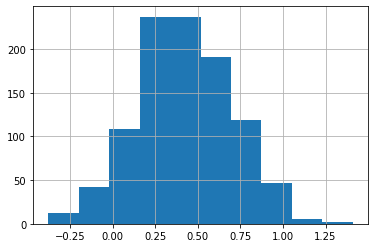

95%-й доверительный интервал: (0.12812323143308443 : 0.9536129820669085)
Средняя прибыль: 0.5182594936973248
Риск убытка: 0.3


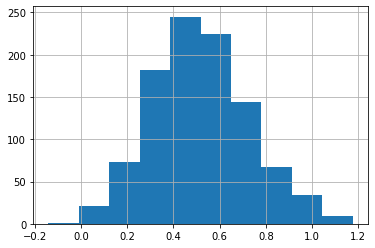

95%-й доверительный интервал: (-0.11585260916001143 : 0.9896299398445739)
Средняя прибыль: 0.4201940053440501
Риск убытка: 6.2


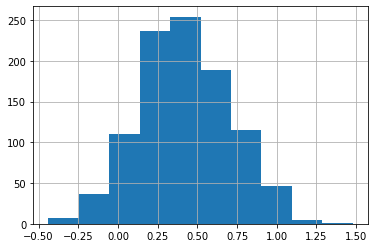

In [19]:
# Bootstrap
values = [[],[],[]]
state = np.random.RandomState(12345)

for i in range(3):
    for j in range(1000):
        target_sample = mass_valid_targets[i].reset_index(drop=True).sample(n = 500, replace = True, random_state=state)
        probs_subsample = mass_predictions[i][target_sample.index]
        
        values[i].append(profit(target_sample, probs_subsample, 200))
        
    values[i] = pd.Series(values[i])
    values[i].hist()
    print('95%-й доверительный интервал: (' + str(values[i].quantile(0.025)) + ' : ' + str(values[i].quantile(0.975)) + ')')
    print('Средняя прибыль:', values[i].mean())
    print('Риск убытка:', stats.percentileofscore(values[i], 0))
    plt.show()

### Вывод
По полученным данным можно сделать вывод, что первый регион больше подходит, так как:
- Доверительный интервал: (0.12812323143308443 : 0.9536129820669085)
- Средняя прибыль в первом регионе: 0.5182594936973248
- Риски: 0.3 %